<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-code,-functions,-etc." data-toc-modified-id="Helper-code,-functions,-etc.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper code, functions, etc.</a></span></li><li><span><a href="#Pre-Processing-of-Data" data-toc-modified-id="Pre-Processing-of-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-Processing of Data</a></span></li><li><span><a href="#Dimension-Reduction:-PLS,-gKDR-Gaussian-RBF,-HSIC-Gaussian-RBF" data-toc-modified-id="Dimension-Reduction:-PLS,-gKDR-Gaussian-RBF,-HSIC-Gaussian-RBF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimension Reduction: PLS, gKDR Gaussian RBF, HSIC Gaussian RBF</a></span><ul class="toc-item"><li><span><a href="#Partial-Least-Squares" data-toc-modified-id="Partial-Least-Squares-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Partial Least Squares</a></span><ul class="toc-item"><li><span><a href="#PLS:-Inspecting-the-Projection-onto-2-Dimensions" data-toc-modified-id="PLS:-Inspecting-the-Projection-onto-2-Dimensions-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>PLS: Inspecting the Projection onto 2 Dimensions</a></span></li><li><span><a href="#PLS:-Inspecting-the-Projection-onto-3-Dimensions" data-toc-modified-id="PLS:-Inspecting-the-Projection-onto-3-Dimensions-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>PLS: Inspecting the Projection onto 3 Dimensions</a></span></li></ul></li><li><span><a href="#gKDR:" data-toc-modified-id="gKDR:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>gKDR:</a></span><ul class="toc-item"><li><span><a href="#gKDR:-Projecting-onto-3-Dimensions:" data-toc-modified-id="gKDR:-Projecting-onto-3-Dimensions:-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>gKDR: Projecting onto 3 Dimensions:</a></span></li></ul></li><li><span><a href="#HSIC:" data-toc-modified-id="HSIC:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>HSIC:</a></span><ul class="toc-item"><li><span><a href="#HSIC:-Projecting-onto-3-Dimensions:" data-toc-modified-id="HSIC:-Projecting-onto-3-Dimensions:-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>HSIC: Projecting onto 3 Dimensions:</a></span></li></ul></li></ul></li></ul></div>

In [4]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

import mogp_emulator

import pandas as pd
import sklearn
import sklearn.metrics
import sklearn.neighbors
import sklearn.cross_decomposition

__Task__:
<img src="anomaly detection/task1.png">

# Helper code, functions, etc.

In [5]:
# HSIC CODE:
import autograd.numpy
from pymanopt.manifolds import Stiefel
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

from scipy.spatial.distance import pdist

global XHSIC, YHSIC, sgx, sgy


def median_distance(X):
    return np.mean(pdist(X))


def gaussian_rbf_gram(MAT1, MAT2, sigma_val):
    """ Computes Gaussian RBF Gram matrix kernel using autograd.numpy:

            k(X, Y) = - exp[||X - Y||^2 / (2sigma^2)]

    REFERENCE: https://github.com/amber0309/HSIC

    Parameters
    ----------
    MAT1 : np.ndarray | Matrix X in the formula.
    MAT2 : np.ndarray | Matrix Y in the formula.
    sigma_val : float | Value for regularising coeff.
    Returns
    -------
    np.ndarray | Gram matrix
        Description of returned object.
    """
    G = autograd.numpy.sum(MAT1*MAT1, 1).reshape(MAT1.shape[0],1)
    H = autograd.numpy.sum(MAT2*MAT2, 1).reshape(MAT2.shape[0],1)

    Q = autograd.numpy.tile(G, (1, MAT2.shape[0]))
    R = autograd.numpy.tile(H.T, (MAT1.shape[0], 1))

    H = Q + R - 2* autograd.numpy.dot(MAT1, MAT2.T)
    return autograd.numpy.exp(-H/2/(sigma_val**2))


def HSIC_gRBF(XMAT, YMAT, sgx, sgy):
    """ Computes the Hilbert-Schmidt Independence Criterion between matrices
        X and Y:

            HSIC = 1/(N - 1)^2 * trace(Gx H Gy H)

    Parameters
    ----------
    XMAT : np.ndarray | Matrix X in the formula.
    YMAT : np.ndarray | Matrix Y in the formula.
    sgx : float | sigma_x parameter in gaussian RBF kernel
    sgy : float | sigma_y parameter in gaussian RBF kernel

    Returns
    -------
    float | value of HSIC calculated
    """
    N, p = XMAT.shape
    HMAT = autograd.numpy.eye(N) - autograd.numpy.ones((N, N))

    Gx = gaussian_rbf_gram(XMAT, XMAT, sgx)

    if len(YMAT.shape) == 2:
        Gy = gaussian_rbf_gram(YMAT, YMAT, sgy)
    elif len(YMAT.shape) == 1:  # Just a vector, convert to column matrix
        Gy = gaussian_rbf_gram(YMAT[:, None], YMAT[:, None], sgy)
    else:
        raise Exception("Error with Y Dimensions")
    return autograd.numpy.trace(Gx @ HMAT @ Gy @ HMAT)


def hsic_cost_function(P):
    """ Helper function for Pymanopt optimisation."""
    global XHSIC, YHSIC, sgx, sgy
    return - HSIC_gRBF(XHSIC @ P, YHSIC, sgx, sgy)

# Pre-Processing of Data

In [6]:
# Importing Data:
twitter_data_folder = "anomaly detection/NAB/data/realTweets/"
ticker_names = ["AAPL", "AMZN", "CRM", "CVS", "FB", "GOOG", "IBM", "KO", "PFE", "UPS"]

full_data = {}
for ticker in ticker_names:
    full_data[ticker] = pd.read_csv(f"{twitter_data_folder}Twitter_volume_{ticker}.csv")

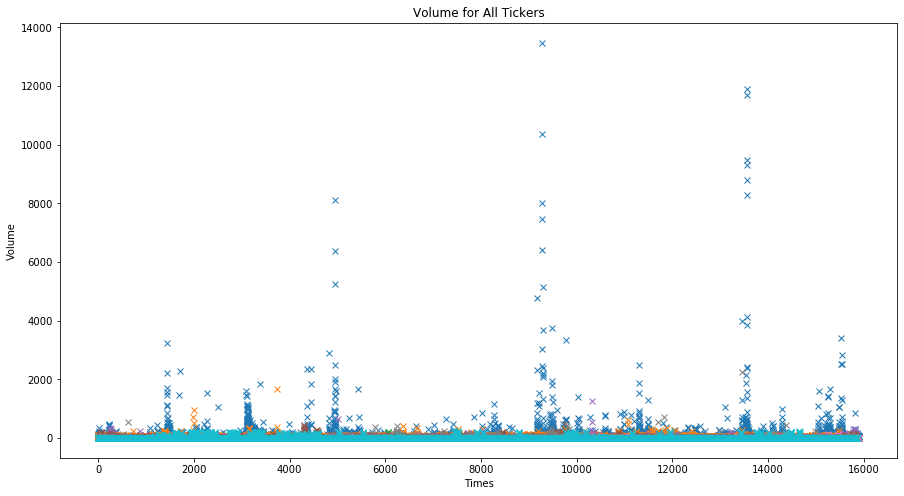

In [7]:
plt.figure(figsize=(15, 8))
for ticker in ticker_names:
    plt.plot(full_data[ticker]["value"], "x", label=f"Volume {ticker}")

plt.ylabel("Volume")
plt.xlabel("Times")
plt.title("Volume for All Tickers")
plt.show()

Now check that all times are properly aligned: (They Are)

In [8]:
# Checking that TimeStamps Align Properly:
df_timestamp = pd.DataFrame()
for ticker in ticker_names:
    df_timestamp[f"Timestamp_{ticker}"] = full_data[ticker]["timestamp"]

time_unique_values =  df_timestamp.apply(pd.Series.nunique, axis=0)
time_unique_values.unique()

array([15902, 15831, 15853, 15833, 15842, 15893, 15851, 15858, 15866],
      dtype=int64)

In [9]:
df_timestamp

,Timestamp_AAPL,Timestamp_AMZN,Timestamp_CRM,Timestamp_CVS,Timestamp_FB,Timestamp_GOOG,Timestamp_IBM,Timestamp_KO,Timestamp_PFE,Timestamp_UPS
0,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53,2015-02-26 21:42:53
1,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53,2015-02-26 21:47:53
2,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53,2015-02-26 21:52:53
3,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53,2015-02-26 21:57:53
4,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53,2015-02-26 22:02:53
...,...,...,...,...,...,...,...,...,...,...
15897,2015-04-23 02:27:53,NaN,2015-04-23 02:27:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15898,2015-04-23 02:32:53,NaN,2015-04-23 02:32:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15899,2015-04-23 02:37:53,NaN,2015-04-23 02:37:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15900,2015-04-23 02:42:53,NaN,2015-04-23 02:42:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


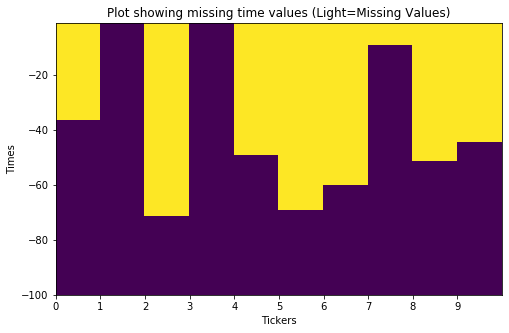

In [18]:
df = pd.DataFrame()
for ticker in ticker_names:
    df[f"Volume_{ticker}"] = full_data[ticker]["value"]
df.insert(0, "TimeStamp", full_data[ticker]["timestamp"])

plt.figure(figsize=(8, 5))
plt.pcolor(range(11), range(-100, 0), df.isnull()[-100:])
plt.xlabel("Tickers")
plt.ylabel("Times")
plt.xticks(range(10))
plt.title("Plot showing missing time values (Light=Missing Values)")
plt.show()

# Drop rows that contain ANY null values, i.e. chop off last 70 or so rows
df.dropna(inplace=True)

In [19]:
# Now ready to begin creating data matrices
time_window = 10
response_ticker = "AAPL"

X = pd.DataFrame()
Y = df[f"Volume_{response_ticker}"][time_window:]
Y.reset_index(drop=True, inplace=True)

for ticker in ticker_names:
    for i in range(1, time_window + 1):
        X[f"Volume_{ticker}_(t-{i})"] = df[f"Volume_{ticker}"][time_window-i:-i].to_numpy()

print(X.shape)
print(Y.shape)

(15821, 100)
(15821,)


This corresponds to having $X \in \mathbb{R}^{n x d}, Y \in \mathbb{R}^n$, where $n = 15821, d = 100$.

In [20]:
saving_folder = "processed_data/"
T = df["TimeStamp"]
X.to_csv(f"{saving_folder}twitter_vol_10win_X.csv")
Y.to_csv(f"{saving_folder}twitter_vol_10win_Y.csv")
T.to_csv(f"{saving_folder}twitter_vol_10win_T.csv")

# Dimension Reduction: PLS, gKDR Gaussian RBF, HSIC Gaussian RBF 

## Partial Least Squares

### PLS: Inspecting the Projection onto 2 Dimensions

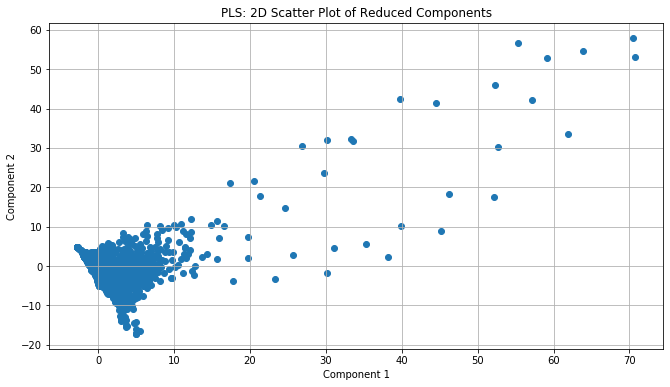

In [32]:
# Dim reduction with 2 components:
PLSRegressor2d = sklearn.cross_decomposition.PLSRegression(n_components=2, scale=True)
PLSRegressor2d.fit(X, Y)
XPLS2d = PLSRegressor2d.transform(X)

# Creating data frame with data:
df_pls2d = pd.DataFrame()
for i in range(2):
    df_pls2d[f"Component_{i+1}"] = XPLS2d[:, i]

df_pls2d["Y"] = Y
df_pls2d.insert(0, "TimeStamp", T[time_window:].to_numpy())

fig = plt.figure(figsize=(11, 6))
plt.scatter(XPLS2d[:, 0], XPLS2d[:, 1])
plt.grid()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PLS: 2D Scatter Plot of Reduced Components")
plt.show()

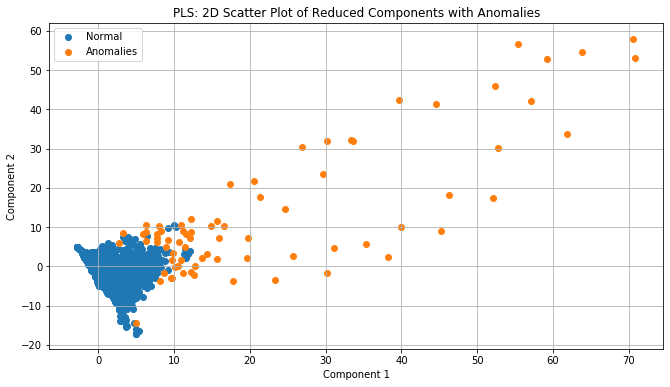

In [38]:
# Inspecting anomalous results by fitting kNN with 5 neighbours
# on the 2D PLS reduced data.
PLS_NN2d = sklearn.neighbors.NearestNeighbors(n_neighbors=5)
PLS_NN2d.fit(XPLS2d)

# Getting Distances to nearest neighbors:
PLS_neigh_dist2d, PLS_neigh_ind2d = PLS_NN2d.kneighbors(XPLS2d, n_neighbors=5)

# Computing average distance to 5 nearest neighbors for each point:
PLS_ave_neigh_dist2d = np.mean(PLS_neigh_dist2d, axis=1)

PLS_mean_ave_neigh_dist2d = np.mean(PLS_ave_neigh_dist2d)
PLS_std_ave_neigh_dist2d = np.std(PLS_ave_neigh_dist2d)

# Setup cutoff point at 3 standard deviations?
PLS_cutoff_point_2d = 3*PLS_std_ave_neigh_dist2d

PLS_normal_points_2d = np.where(PLS_ave_neigh_dist2d <= PLS_cutoff_point_2d)[0]
PLS_anomalies_2d = np.where(PLS_ave_neigh_dist2d > PLS_cutoff_point_2d)[0]

fig = plt.figure(figsize=(11, 6))
plt.scatter(XPLS2d[PLS_normal_points_2d, 0], XPLS2d[PLS_normal_points_2d, 1], label="Normal")
plt.scatter(XPLS2d[PLS_anomalies_2d, 0], XPLS2d[PLS_anomalies_2d, 1], label="Anomalies")
plt.legend()
plt.grid()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PLS: 2D Scatter Plot of Reduced Components with Anomalies")
plt.show()

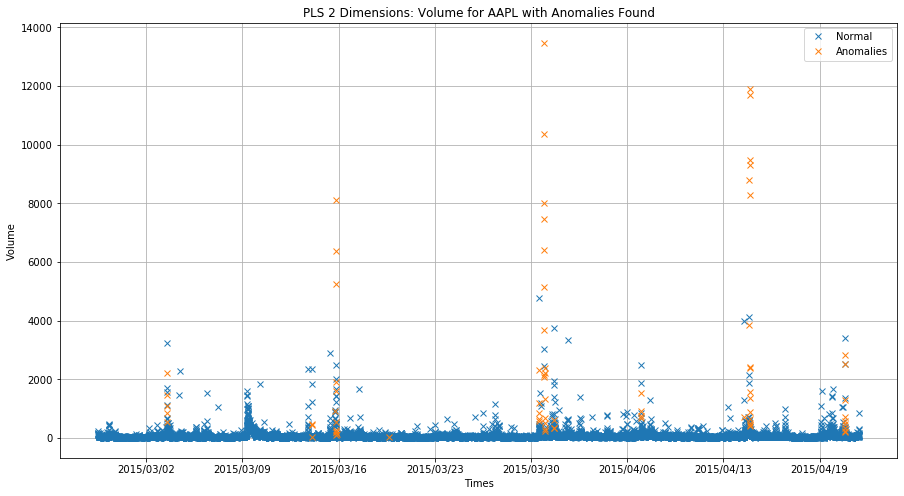

In [34]:
# Visualising Actual Anomalies:
time_ticks = np.arange(1000, 15820, 2000)
time_labels = pd.to_datetime(T[10:][time_ticks]).dt.strftime("%Y/%m/%d")

plt.figure(figsize=(15, 8))
plt.plot(Y[PLS_normal_points_2d], "x", label="Normal")
plt.plot(Y[PLS_anomalies_2d], "x", label="Anomalies")
plt.legend()
plt.grid()
plt.ylabel("Volume")
plt.xlabel("Times")

plt.xticks(time_ticks, labels=time_labels)

plt.title("PLS 2 Dimensions: Volume for AAPL with Anomalies Found")
plt.show()

### PLS: Inspecting the Projection onto 3 Dimensions

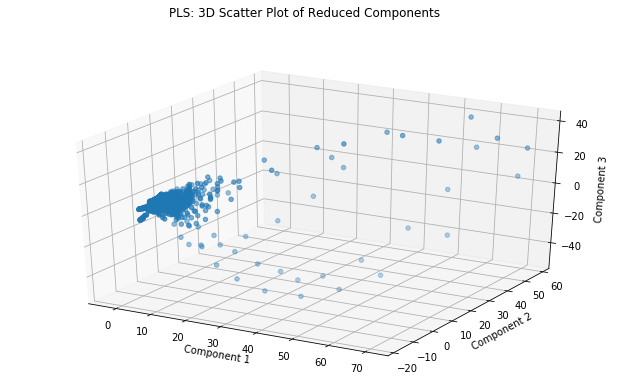

In [36]:
PLSRegressor3d = sklearn.cross_decomposition.PLSRegression(
                    n_components=3, scale=True)
PLSRegressor3d.fit(X, Y)

XPLS3d = PLSRegressor3d.transform(X)

df_pls3d = pd.DataFrame()
for i in range(3):
    df_pls3d[f"Component_{i+1}"] = XPLS3d[:, i]

df_pls3d["Y"] = Y
df_pls3d.insert(0, "TimeStamp", T[time_window:].to_numpy())

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XPLS3d[:, 0], XPLS3d[:, 1], XPLS3d[:, 2])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("PLS: 3D Scatter Plot of Reduced Components")
plt.show()

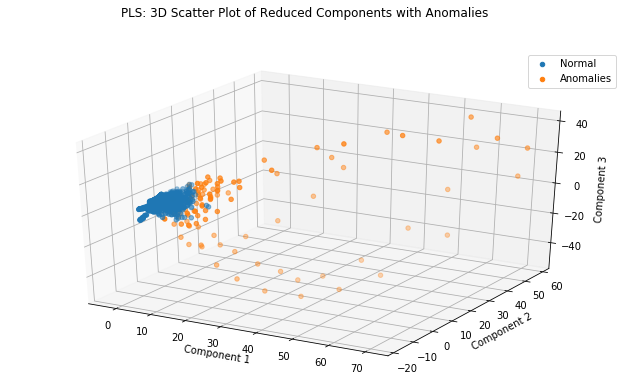

In [114]:
PLS_NN3d = sklearn.neighbors.NearestNeighbors(n_neighbors=5)

PLS_NN3d.fit(XPLS3d)

# Getting Distances to nearest neighbors:
PLS_neigh_dist3d, PLS_neigh_ind3d = PLS_NN3d.kneighbors(XPLS3d, n_neighbors=5)

# Computing average distance to 5 nearest neighbors for each point:
PLS_ave_neigh_dist3d = np.mean(PLS_neigh_dist3d, axis=1)

PLS_mean_ave_neigh_dist3d = np.mean(PLS_ave_neigh_dist3d)
PLS_std_ave_neigh_dist3d = np.std(PLS_ave_neigh_dist3d)

# Setup cutoff point at 3 standard deviations?
PLS_cutoff_point_3d = 3*PLS_std_ave_neigh_dist3d

PLS_normal_points_3d = np.where(PLS_ave_neigh_dist3d <= PLS_cutoff_point_3d)[0]
PLS_anomalies_3d = np.where(PLS_ave_neigh_dist3d > PLS_cutoff_point_3d)[0]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XPLS3d[PLS_normal_points_3d, 0], XPLS3d[PLS_normal_points_3d, 1], 
            XPLS3d[PLS_normal_points_3d, 2], label="Normal")
ax.scatter(XPLS3d[PLS_anomalies_3d, 0], XPLS3d[PLS_anomalies_3d, 1], 
            XPLS3d[PLS_anomalies_3d, 2], label="Anomalies")
plt.legend()
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("PLS: 3D Scatter Plot of Reduced Components with Anomalies")
plt.savefig("fig4.01.png")
plt.show()

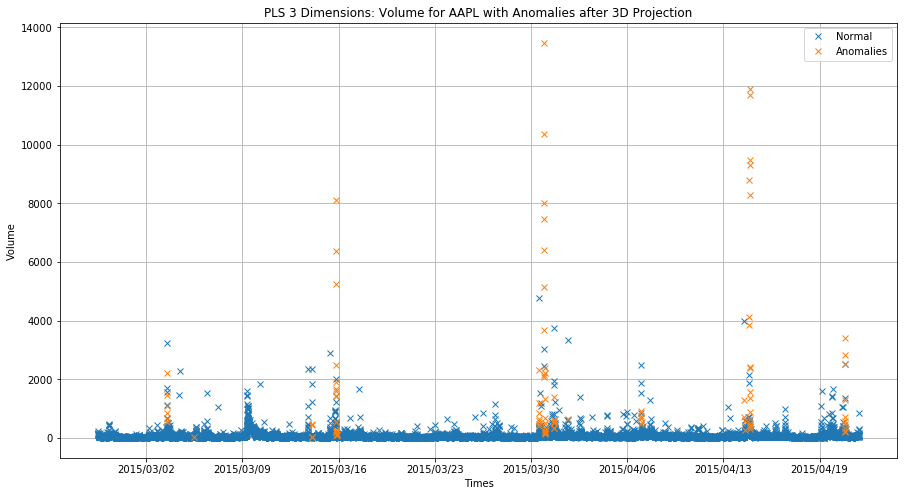

In [115]:
# Plot on Y graph:
time_ticks = np.arange(1000, 15820, 2000)
time_labels = pd.to_datetime(T[10:][time_ticks]).dt.strftime("%Y/%m/%d")

plt.figure(figsize=(15, 8))
plt.plot(Y[PLS_normal_points_3d], "x", label="Normal")
plt.plot(Y[PLS_anomalies_3d], "x", label="Anomalies")
plt.legend()
plt.grid()
plt.ylabel("Volume")
plt.xlabel("Times")

plt.xticks(time_ticks, labels=time_labels)

plt.title("PLS 3 Dimensions: Volume for AAPL with Anomalies after 3D Projection")
plt.savefig("fig4.02.png")
plt.show()

In [90]:
print("Partial Least Squares Results:")
print(f"Number of anomalies found 2D = {PLS_anomalies_2d.size}")
print(f"Number of anomalies found 3D = {PLS_anomalies_3d.size}")

print("Largest anomalies dates found:")
print(T[np.argsort(Y[PLS_anomalies_3d])[-10:]])

Partial Least Squares Results:
Number of anomalies found 2D = 75
Number of anomalies found 3D = 99
Largest anomalies dates found:
38    2015-02-27 00:52:53
16    2015-02-26 23:02:53
74    2015-02-27 03:52:53
72    2015-02-27 03:42:53
77    2015-02-27 04:07:53
73    2015-02-27 03:47:53
36    2015-02-27 00:42:53
75    2015-02-27 03:57:53
76    2015-02-27 04:02:53
37    2015-02-27 00:47:53
Name: TimeStamp, dtype: object


## gKDR:

### gKDR: Projecting onto 3 Dimensions:

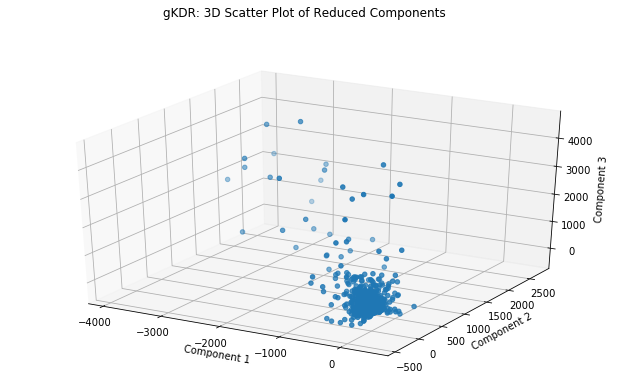

In [103]:
gKDR_3d = mogp_emulator.gKDR(X[0:100].to_numpy(), Y[0:100].to_numpy(), 3)

XGKDR3d = gKDR_3d(X.to_numpy())

df_gkdr3d = pd.DataFrame()
for i in range(3):
    df_gkdr3d[f"Component_{i+1}"] = XGKDR3d[:, i]

df_gkdr3d["Y"] = Y
df_gkdr3d.insert(0, "TimeStamp", T[time_window:].to_numpy())

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XGKDR3d[:, 0], XGKDR3d[:, 1], XGKDR3d[:, 2])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("gKDR: 3D Scatter Plot of Reduced Components")
plt.show()

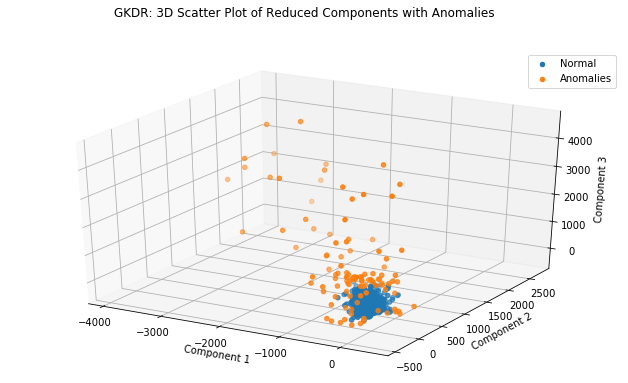

In [116]:
GKDR_NN3d = sklearn.neighbors.NearestNeighbors(n_neighbors=5)

GKDR_NN3d.fit(XGKDR3d)

# Getting Distances to nearest neighbors:
GKDR_neigh_dist3d, GKDR_neigh_ind3d = GKDR_NN3d.kneighbors(XGKDR3d, n_neighbors=5)

# Computing average distance to 5 nearest neighbors for each point:
GKDR_ave_neigh_dist3d = np.mean(GKDR_neigh_dist3d, axis=1)

GKDR_mean_ave_neigh_dist3d = np.mean(GKDR_ave_neigh_dist3d)
GKDR_std_ave_neigh_dist3d = np.std(GKDR_ave_neigh_dist3d)

# Setup cutoff point at 3 standard deviations?
GKDR_cutoff_point_3d = 3*GKDR_std_ave_neigh_dist3d

GKDR_normal_points_3d = np.where(GKDR_ave_neigh_dist3d <= GKDR_cutoff_point_3d)[0]
GKDR_anomalies_3d = np.where(GKDR_ave_neigh_dist3d > GKDR_cutoff_point_3d)[0]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XGKDR3d[GKDR_normal_points_3d, 0], XGKDR3d[GKDR_normal_points_3d, 1], 
            XGKDR3d[GKDR_normal_points_3d, 2], label="Normal")
ax.scatter(XGKDR3d[GKDR_anomalies_3d, 0], XGKDR3d[GKDR_anomalies_3d, 1], 
            XGKDR3d[GKDR_anomalies_3d, 2], label="Anomalies")
plt.legend()
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("GKDR: 3D Scatter Plot of Reduced Components with Anomalies")
plt.savefig("fig4.03.png")
plt.show()

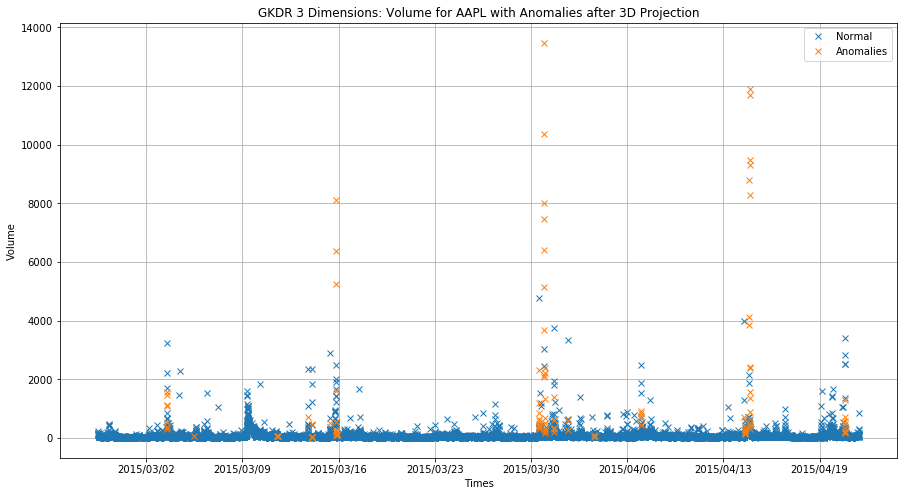

In [117]:
# Plot on Y graph:
time_ticks = np.arange(1000, 15820, 2000)
time_labels = pd.to_datetime(T[10:][time_ticks]).dt.strftime("%Y/%m/%d")

plt.figure(figsize=(15, 8))
plt.plot(Y[GKDR_normal_points_3d], "x", label="Normal")
plt.plot(Y[GKDR_anomalies_3d], "x", label="Anomalies")
plt.legend()
plt.grid()
plt.ylabel("Volume")
plt.xlabel("Times")

plt.xticks(time_ticks, labels=time_labels)

plt.title("GKDR 3 Dimensions: Volume for AAPL with Anomalies after 3D Projection")
plt.savefig("fig4.04.png")
plt.show()

In [112]:
print("GKDR Results:")
print(f"Number of anomalies found 3D = {GKDR_anomalies_3d.size}")

print("Largest anomalies dates found:")
print(T[np.argsort(Y[GKDR_anomalies_3d])[-10:]])

GKDR Results:
Number of anomalies found 3D = 109
Largest anomalies dates found:
45    2015-02-27 01:27:53
20    2015-02-26 23:22:53
87    2015-02-27 04:57:53
85    2015-02-27 04:47:53
90    2015-02-27 05:12:53
86    2015-02-27 04:52:53
43    2015-02-27 01:17:53
88    2015-02-27 05:02:53
89    2015-02-27 05:07:53
44    2015-02-27 01:22:53
Name: TimeStamp, dtype: object


## HSIC:

### HSIC: Projecting onto 3 Dimensions:

In [73]:
XHSIC = autograd.numpy.array(X[0:500].copy())
YHSIC = autograd.numpy.array(Y[0:500].copy())

# Train HSIC method on training data:
# Finding optimal sgx, sgy using gKDR method of median distance:
sgx = 0.2 #median_distance(XHSIC)
sgy = median_distance(YHSIC[:, None])

# Perform manifold learning:
manifold = Stiefel(100, 3)
problem = Problem(manifold=manifold, cost=hsic_cost_function)
solver = SteepestDescent()
Popt_HSIC_3D = solver.solve(problem)

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	-8.2909540088403523e+07	1.01057110e+07
    2	-8.2983451304086775e+07	3.30713210e+07
    3	-8.3350963178699672e+07	1.92245640e+08
    4	-8.3582396764305770e+07	1.60410723e+08
    5	-8.3618994560043305e+07	3.00899768e+08
    6	-8.3758267861840099e+07	2.57832918e+08
    7	-8.3878352068011671e+07	1.01904389e+08
    8	-8.3890944116378099e+07	2.65143400e+07
    9	-8.3891993696883410e+07	2.47784620e+07
   10	-8.3893006012447208e+07	1.63869349e+07
   11	-8.3893721409647524e+07	2.52069395e+07
   12	-8.3894313680357546e+07	2.38803366e+07
   13	-8.3894922311879903e+07	1.97493585e+07
   14	-8.3895495312541172e+07	1.08241441e+07
   15	-8.3895778865461737e+07	2.13198599e+07
   16	-8.3896367347285554e+07	7.13331965e+06
   17	-8.3896470031976938e+07	3.19498117e+07
   18	-8.3896845263918370e+07	2.64250315e+07
   19	-8.3897650620635003e+07	2.55720889e+06
   20	-8.3897659906619594e+07	4.56439101e+06


  181	-8.4226621008528918e+07	2.62347906e+07
  182	-8.4227354945209950e+07	1.19641278e+07
  183	-8.4227654670979097e+07	1.27696695e+07
  184	-8.4227921947994649e+07	9.17514691e+06
  185	-8.4228080310515016e+07	1.25568213e+07
  186	-8.4228261997020796e+07	9.88762557e+06
  187	-8.4228403621284306e+07	7.04721577e+06
  188	-8.4228479517459869e+07	8.90646359e+06
  189	-8.4228580319109082e+07	6.53283732e+06
  190	-8.4228640951262251e+07	6.64669238e+06
  191	-8.4228669229690760e+07	8.54099845e+06
  192	-8.4228749185207456e+07	4.03089040e+06
  193	-8.4228764755047798e+07	8.87538504e+06
  194	-8.4228817295561969e+07	6.16378693e+06
  195	-8.4228822593969882e+07	8.25509832e+06
  196	-8.4228842491001785e+07	7.25271707e+06
  197	-8.4228899147125393e+07	3.46082636e+06
  198	-8.4228908037779987e+07	7.59830060e+06
  199	-8.4228939318658814e+07	5.80262154e+06
  200	-8.4228981134702921e+07	4.09002335e+06
  201	-8.4229005962614447e+07	4.57924879e+06
  202	-8.4229031277486891e+07	4.80653639e+06
  203	-8.4

  364	-8.4558434079912364e+07	4.40178378e+04
  365	-8.4558434081306785e+07	4.26356521e+04
  366	-8.4558434083413363e+07	2.02342895e+04
  367	-8.4558434084497303e+07	2.19757409e+04
  368	-8.4558434085450187e+07	2.09846637e+04
  369	-8.4558434086420327e+07	1.91942224e+04
  370	-8.4558434087341949e+07	2.22796417e+04
  371	-8.4558434087551355e+07	1.63382957e+04
  372	-8.4558434088100344e+07	1.17931492e+04
  373	-8.4558434089243069e+07	2.74604953e+04
  374	-8.4558434090028450e+07	1.23610310e+04
  375	-8.4558434090213329e+07	3.05196134e+04
  376	-8.4558434090859890e+07	2.09060038e+04
  377	-8.4558434091417879e+07	9.96882988e+03
  378	-8.4558434091562748e+07	1.14291010e+04
  379	-8.4558434091809511e+07	1.09605325e+04
  380	-8.4558434092154577e+07	9.81978100e+03
  381	-8.4558434092481598e+07	1.50060555e+04
  382	-8.4558434092640892e+07	8.20260108e+03
  383	-8.4558434092915758e+07	1.31706284e+04
  384	-8.4558434093088627e+07	2.07650357e+04
  385	-8.4558434093819141e+07	9.18947053e+03
  386	-8.4

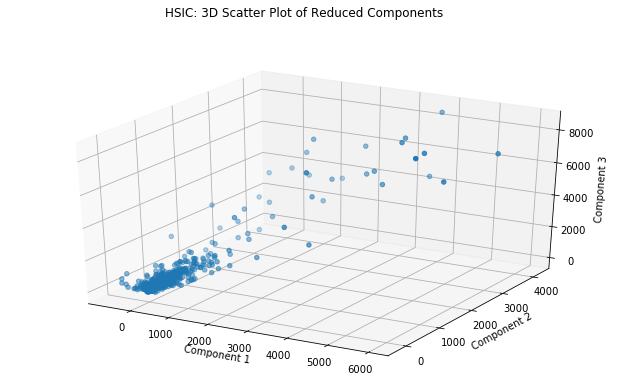

In [104]:
XHSIC3d = (X @ Popt_HSIC_3D).to_numpy()

df_hsic3d = pd.DataFrame()
for i in range(3):
    df_hsic3d[f"Component_{i+1}"] = XHSIC3d[:, i]

df_hsic3d["Y"] = Y
df_hsic3d.insert(0, "TimeStamp", T[time_window:].to_numpy())

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XHSIC3d[:, 0], XHSIC3d[:, 1], XHSIC3d[:, 2])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("HSIC: 3D Scatter Plot of Reduced Components")
plt.show()

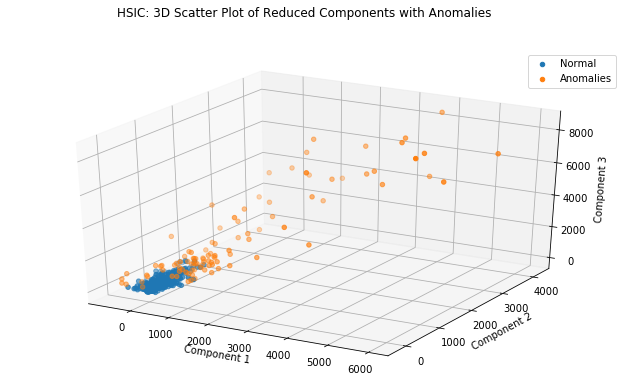

In [118]:
HSIC_NN3d = sklearn.neighbors.NearestNeighbors(n_neighbors=5)

HSIC_NN3d.fit(XHSIC3d)

# Getting Distances to nearest neighbors:
HSIC_neigh_dist3d, HSIC_neigh_ind3d = HSIC_NN3d.kneighbors(XHSIC3d, n_neighbors=5)

# Computing average distance to 5 nearest neighbors for each point:
HSIC_ave_neigh_dist3d = np.mean(HSIC_neigh_dist3d, axis=1)

HSIC_mean_ave_neigh_dist3d = np.mean(HSIC_ave_neigh_dist3d)
HSIC_std_ave_neigh_dist3d = np.std(HSIC_ave_neigh_dist3d)

# Setup cutoff point at 3 standard deviations?
HSIC_cutoff_point_3d = 3*HSIC_std_ave_neigh_dist3d

HSIC_normal_points_3d = np.where(HSIC_ave_neigh_dist3d <= HSIC_cutoff_point_3d)[0]
HSIC_anomalies_3d = np.where(HSIC_ave_neigh_dist3d > HSIC_cutoff_point_3d)[0]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(XHSIC3d[HSIC_normal_points_3d, 0], XHSIC3d[HSIC_normal_points_3d, 1], 
            XHSIC3d[HSIC_normal_points_3d, 2], label="Normal")
ax.scatter(XHSIC3d[HSIC_anomalies_3d, 0], XHSIC3d[HSIC_anomalies_3d, 1], 
            XHSIC3d[HSIC_anomalies_3d, 2], label="Anomalies")
plt.legend()
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.suptitle("HSIC: 3D Scatter Plot of Reduced Components with Anomalies")
plt.savefig("fig4.05.png")
plt.show()

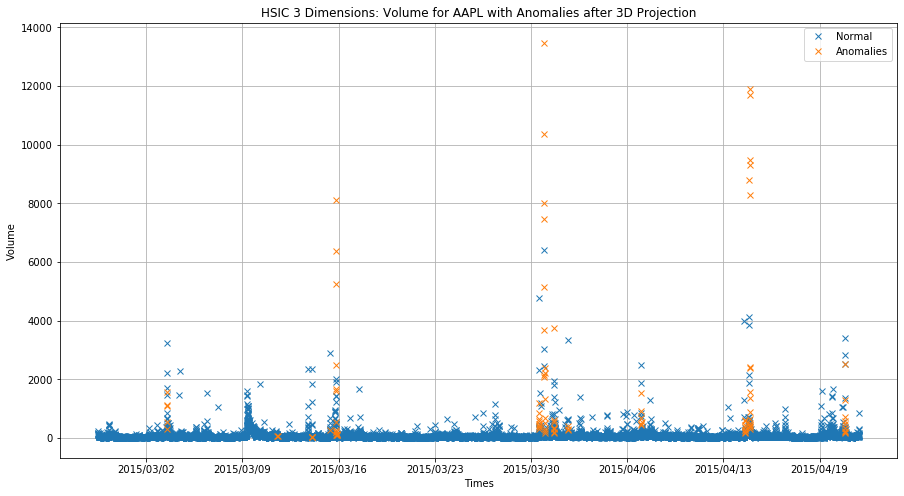

In [119]:
# Plot on Y graph:
time_ticks = np.arange(1000, 15820, 2000)
time_labels = pd.to_datetime(T[10:][time_ticks]).dt.strftime("%Y/%m/%d")

plt.figure(figsize=(15, 8))
plt.plot(Y[HSIC_normal_points_3d], "x", label="Normal")
plt.plot(Y[HSIC_anomalies_3d], "x", label="Anomalies")
plt.legend()
plt.grid()
plt.ylabel("Volume")
plt.xlabel("Times")

plt.xticks(time_ticks, labels=time_labels)

plt.title("HSIC 3 Dimensions: Volume for AAPL with Anomalies after 3D Projection")
plt.savefig("fig4.06.png")
plt.show()

In [109]:
print("HSIC Results:")
print(f"Number of anomalies found 3D = {HSIC_anomalies_3d.size}")

print("Largest anomalies dates found:")
print(T[np.argsort(Y[HSIC_anomalies_3d])[-10:]])

HSIC Results:
Number of anomalies found 3D = 101
Largest anomalies dates found:
37    2015-02-27 00:47:53
14    2015-02-26 22:52:53
77    2015-02-27 04:07:53
75    2015-02-27 03:57:53
80    2015-02-27 04:22:53
76    2015-02-27 04:02:53
35    2015-02-27 00:37:53
78    2015-02-27 04:12:53
79    2015-02-27 04:17:53
36    2015-02-27 00:42:53
Name: TimeStamp, dtype: object
